### Covariance analyses on Marius' V1 receptive field data. 
The receptive fields were calculated in response to discrete hartley basis functions

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [50]:
def load_V1_Marius_DHT(data_dir = 'data/V1_data_Marius/', centered=True, normalized=True):
    '''
    Loads the V1 receptive fields dataset given by Marius Pachitariu. 4k neurons were
    shown hartley basis functions repeatedly and their RFs were calculated. In the data, 
    the RF sizes are 30 x 80. We normalize the RFs and center them for analysis.
    
    Parameters
    ----------
    data_dir: string, default='.data/V1_data_Marius/' 
        Path to the receptive field data folder
    
    centered: bool, default=True
        If True, centers the receptive fields to (15, 40) pixel coordinate using
        the image's center of mass.
    
    normalized: bool, default=True
        If True, the mean of RF values is set to 0 and std dev is set to 1. 
    
    Returns
    -------
    processed_RFs: (array-like) of shape (4337, 2400)
        Receptive fieds of ~4k neurons.
        
    '''
    
    import numpy as np
    from scipy import ndimage
    
    # load data
    with np.load(data_dir + 'rf_DHT.npz') as data:
        RF_Marius = data['rf']
        snr = data['snr']
    
    xdim, ydim, num_cells = RF_Marius.shape
    processed_RF = np.zeros((num_cells, xdim * ydim))
    
    for cell in range(num_cells):
        cell_rf = RF_Marius[:, :, cell]

        # normalize
        if normalized == True:
            cell_rf = (cell_rf - np.mean(cell_rf)) / np.std(cell_rf)

        # center
        if centered == True:
            center_of_mass = ndimage.measurements.center_of_mass(np.abs(cell_rf) ** 5)
            center_of_mass = np.round(center_of_mass).astype('int')

            # translate to (12, 13) but wrap around
            cell_rf_centered = np.roll(cell_rf, 15 - center_of_mass[0], axis=0)
            cell_rf_centered = np.roll(cell_rf_centered, 40 - center_of_mass[1], axis=1)
            processed_RF[cell] = cell_rf_centered.flatten()

        elif centered == False:
            processed_RF[cell] = cell_rf.flatten()
            
    return processed_RF, snr 

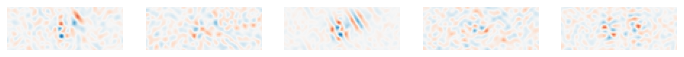

In [85]:
data_dir = 'data/V1_data_Marius/'
rf_data, snr = load_V1_Marius_DHT(data_dir, centered=True, normalized=True)
rf = rf_data[snr > 0]

fig = plt.figure(figsize=(12, 5))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1)
    i = np.random.randint(len(rf))
    plt.imshow(rf[i].reshape(30, 80), cmap='RdBu')
    plt.clim(-10, 10)
    plt.axis('off')

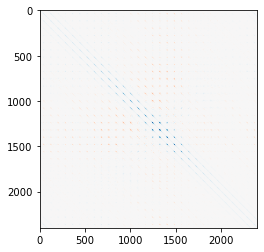

In [87]:
# compute data covariance
cov_data = rf.T @ rf
cov_data *= cov_data.shape[1] / np.trace(cov_data)

fig = plt.figure()
plt.imshow(cov_data, cmap='RdBu')
plt.clim(-2, 2)
# plt.xlim(500, 1500)
# plt.ylim(500, 1500)

In [88]:
rf.shape

(4371, 2400)